In [818]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [819]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import math

## NOTES ON TO TEST
1. Figure out `n_flow_staff` necessary to not have wait time at `refine_complaint` under normal ops (no `offset`, currently at `flow_staff = 20` there appears to be a little bit of a wait
    - Could be done using gradient descent that increases `n_flow_staff` to get to wait time of `0`
2. Figure out balance between increasing `offload` and `flow_staff` to find point at which (a) no wait at `exam` 

## Changes from v10

The goal is to test whether making the process such that flow staff follows patient through `refine_complaint`, `exam`, and `follow_up` steps can increase patient flow and reduce wait times.

This requires reformatting the process flow so that a second `FlowStaff` server dictionary carries through those 3 steps to ensure that that particular server is always occupied, while also maintaining the original process setup that creates wait times between steps.

A parameter `offload` is then introduced to determine how much of `Provider` time can be saved and therefore reduce wait times. This creates three components of the overall `serve_time_exam` that the patient spends at the `exam` step:
- `serve_time_exam_flowstaff = serve_time_exam`
- `serve_time_exam_provider = serve_time_exam * (1 - offload)`
- `provider_time_saved = serve_time_exam * offload`

where these pieces fit together like:

<img src="11_offload_servetime_diagram.png" width = 650>

The `Provider` is then freed up a little bit sooner to attend to the next patient. As the `Provider` is bottleneck resource, this should in theory reduce wait times overall.

## Functions

Updated for v11 with moving random draws before simulation

*Same as originals*

In [820]:
def generate_service_distribution_type_condition(data, condition_type, minimum = 2, skew = 0.05, n_samples = 10000) :
    # Average service time for condition
    avg = data.loc[data['Type'] == condition_type, 'Time_Mean'].item()
    # Worst case upper limit for condition
    worstcase = data.loc[data['Type'] == condition_type, 'Time_WorstCase'].item()
    # % of time worst case for condition
    perc_worst_case = data.loc[data['Type'] == condition_type, 'Perc_WorstCase'].item()
    # St Dev based on % of time worst case occurs
    std = worstcase / stats.skewnorm.ppf(1 - perc_worst_case, avg)
    # Create distribution of 1000 samples based on condition type parameters
    dist = stats.skewnorm.rvs(skew, loc = avg, scale = std, size = n_samples)
    # Remove negative / too low results
    dist[dist < avg / minimum] = avg / minimum
    return dist

In [821]:
def generate_service_distribution_process(data, process, minimum = 2, skew = 0.05, n_samples = 10000) :
    # Average service time for condition
    avg = data.loc[data['Process'] == process, 'Time_Mean'].item()
    # Worst case upper limit for condition
    worstcase = data.loc[data['Process'] == process, 'Time_WorstCase'].item()
    # % of time worst case for condition
    perc_worst_case = data.loc[data['Process'] == process, 'Perc_WorstCase'].item()
    # St Dev based on % of time worst case occurs
    std = worstcase / stats.skewnorm.ppf(1 - perc_worst_case, avg)
    # Create distribution of 1000 samples based on condition type parameters
    dist = stats.skewnorm.rvs(skew, loc = avg, scale = std, size = n_samples)
    # Remove negative / too low results
    dist[dist < avg / minimum] = avg / minimum
    return dist

In [822]:
def generate_service_time_type_condition(dist_dict) :
    """Get randomized service time based on type of condition
    To be used only if step in model is Exam by provider"""
    # Randomly choose type of condition, based on preexisting known probabilities
    cond_type = ['Chronic', 'Preventative', 'Acute']
    p_cond_type = [0.6, 0.2, 0.2]
    type = np.random.choice(cond_type, p = p_cond_type)
    # Return randomly chosen new service type from previously generated distributions
    serve_time = np.random.choice(dist_dict[type])
    return round(serve_time)

In [823]:
def generate_service_time_process(process, process_dict) :
    """Get randomized service time based on process
    To be used only all steps in model except Exam by provider"""
    serve_time = np.random.choice(process_dict[process])
    return round(serve_time)

In [824]:
def mark_service_time(dictionary_service, count_of_completed_service, service_time_tracker_dict, list_service_times_completed) :
    """Reduce the service time left for each patient to complete step by 1
    If service time  reduced to zero, remove patient from  dictionary, move to service completed, free up server
    Return modified service time dictionary
    In parallel, track completed service times to generate avg service time estimate post-simulation"""
    # Reduce service time left to complete step
    for k, v in dictionary_service.items() :
        if np.isnan(v) :
            continue
        else :
            dictionary_service[k] -= 1
            # Count patient as completed step and free up server if service time is 0
            if dictionary_service[k] == 0 :
                count_of_completed_service += 1
                dictionary_service[k] = np.nan
    # For patients who are marked as completed, track the actual service time
    # completion for noting after simulation
    keys_for_removal = list()
    for k in service_time_tracker_dict.keys() :
        service_time_tracker_dict[k][0] += 1
        if service_time_tracker_dict[k][0] == service_time_tracker_dict[k][1] :
            list_service_times_completed.append(service_time_tracker_dict[k][1])
            keys_for_removal.append(k)
    for k in keys_for_removal :
        del service_time_tracker_dict[k]
    return dictionary_service, count_of_completed_service, list_service_times_completed

In [825]:
def check_servers_free(dictionary_service) :
    """Verify if servers are free (denoted by np.nan as value for server key)
    And, if free servers exist, how many"""
    count_servers_free = 0
    for k, v in dictionary_service.items() :
        if np.isnan(v) :
            count_servers_free += 1
    return count_servers_free

In [826]:
def how_many_to_move_from_where(dictionary_waiting, count_servers_free, count_n_arrivals) :
    """Determine how many people to move from wait list to service / from new arrivals to service"""
    count_from_wait_list = min(len(dictionary_waiting.keys()), count_servers_free)
    count_servers_free = count_servers_free - count_from_wait_list
    count_from_new_arrivals = min(count_n_arrivals, count_servers_free)
    return count_from_wait_list, count_from_new_arrivals

In [827]:
def move_from_wait_list_to_service(dictionary_waiting, dictionary_service, count_from_wait_list, list_waiting_time, service_time_tracker_dict, process, empty_servers = True) :
    """Move patients from wait list to free servers
    To be preceded by: if count_from_wait_list > 0"""
    if empty_servers == True : # empty_servers = True for steps not using flow staff otherwise empty_servers pre-defined
        empty_servers = [k for k, v in dictionary_service.items() if np.isnan(v)]
    n_free_servers = len(empty_servers)
    patients_on_wait_list = list(dictionary_waiting.keys()) # Remove sort to fix bug with sorting 9 / 10
    patients_move_to_serve = patients_on_wait_list[:n_free_servers]
    if (len(patients_move_to_serve) > 0) and (len(empty_servers) > 0) :
        for i, m in enumerate(patients_move_to_serve) :
            server_for_m = empty_servers[i]
            list_waiting_time.append(dictionary_waiting[m])
            del dictionary_waiting[m]
            if process == 'Exam' :
                serve_time = generate_service_time_type_condition(distribs_dict_type)
            else :
                serve_time = generate_service_time_process(process, distribs_dict_process)
                if process == 'Refine_complaint' :
                    serve_time += pass_through_steps['Time_Mean'].sum()
            dictionary_service[server_for_m] = serve_time
            unique_key = 'Service_' + str(serve_time) + '_' + str(p)
            service_time_tracker_dict[unique_key] = [0, serve_time]
    return dictionary_waiting, dictionary_service, list_waiting_time, service_time_tracker_dict

In [828]:
def move_from_arrival_to_service(dictionary_service, count_from_new_arrivals, service_time_tracker_dict, process) :
    """Move patients from arrivals to free servers
    To be preceded by: if count_from_new_arrivals > 0 """
    empty_servers = [k for k, v in dictionary_service.items() if np.isnan(v)]
    arrivals_to_place = min(len(empty_servers), count_from_new_arrivals)
    if (arrivals_to_place > 0) and (len(empty_servers) > 0) :
        for i in range(arrivals_to_place) :
            server_for_m = empty_servers[i]
            if process == 'Exam' :
                serve_time = generate_service_time_type_condition(distribs_dict_type)
            else :
                serve_time = generate_service_time_process(process, distribs_dict_process)
                if process == 'Refine_complaint' :
                    serve_time += pass_through_steps['Time_Mean'].sum()
            dictionary_service[server_for_m] = serve_time
            unique_key = 'Service_' + str(serve_time) + '_' + str(p)
            service_time_tracker_dict[unique_key] = [0, serve_time]
    return dictionary_service, arrivals_to_place, service_time_tracker_dict

In [829]:
def add_to_wait_list(dictionary_waiting, count_n_arrivals, count_arrivals_placed) :
    """Move patients from arrivals to wait list
    To be preceded by: if arrivals_placed < n_arrivals"""
    count_diff = count_n_arrivals - count_arrivals_placed
    wait_keys = list(dictionary_waiting.keys()) # Remove sort to fix bug with sorting 9 / 10
    for i in range(count_diff) :
        if len(wait_keys) < 1 :
            new_waitname = 'Waiting' + str(i)
            dictionary_waiting[new_waitname] = 1
        else :
            count_lastwaiter = int(wait_keys[-1][7:])
            new_waitname = 'Waiting' + str(count_lastwaiter + i + 1)
            dictionary_waiting[new_waitname] = 1
    return dictionary_waiting

In [830]:
def generate_step_objects(n_servers, n_periods) :
    """Function to generate step tracking objects"""
    # Treat servers as dictionary to keep track of who is busy
    # NaN means empty server
    # If busy, dict will take form of {'Server#': n_minutes_left_service}
    dictionary_servers = {}
    for i in range(n_servers) :
        servname = 'Server' + str(i)
        dictionary_servers[servname] = np.nan
    # Treat waiting as dictionary
    # If someone waits, will be added to dictionary with form of {'Waiting#': n_minutes_waiting}
    dictionary_waiting = {}
    # Temporary tracker dictionary for service times
    dictionary_track_serve_time = {}
    # Holding lists for completed service times and completed waiting times (for measurement post-simulation)
    list_waiting_times = list()
    list_service_completed_times = list()
    # Set counter for completed service to 0
    count_service_completed = 0
    # Array for holding onto step-by-step process
    # Shape: number_of_periods x 4 -> [n_arrivals, n_being_served, n_waiting, n_completed]
    tracker = np.zeros(shape = (n_periods, 4))
    return dictionary_servers, dictionary_waiting, dictionary_track_serve_time, list_waiting_times, list_service_completed_times, count_service_completed, tracker

In [831]:
def max_try_except(wait_time_list) :
    """Function to calculate summary stat of maximum wait times
    Requires try/except block for np.max returning error when no wait times in list"""
    try :
        return np.max(wait_time_list)
    except :
        return 0

*Rewritten for flow staff / exam step*

In [832]:
def mark_service_time_flow_staff_steps(dictionary_service, count_of_completed_service, service_time_tracker_dict, list_service_times_completed, flowstaff = True) :
    """Reduce the service time left for each patient to complete step by 1
    If service time  reduced to zero, remove patient from  dictionary, move to service completed, free up server
    Return modified service time dictionary
    In parallel, track completed service times to generate avg service time estimate post-simulation"""
    # List of servers to move over (if patient completes step)
    move_to_next_step = list()
    # Reduce service time left to complete step
    for k, v in dictionary_service.items() :
        if np.isnan(v) :
            continue
        else :
            dictionary_service[k] -= 1
            # Count patient as completed step and free up server if service time is 0
            if dictionary_service[k] == 0 :
                count_of_completed_service += 1
                move_to_next_step.append(k)
                if flowstaff == True :
                    dictionary_service[k] = np.inf # Hold as np.inf until reset -- ensure server not double used
                else :
                    dictionary_service[k] = np.nan # For if function being used on provider service dict
    # For patients who are marked as completed, track the actual service time
    # completion for noting after simulation
    keys_for_removal = list()
    for k in service_time_tracker_dict.keys() :
        service_time_tracker_dict[k][0] += 1
        if service_time_tracker_dict[k][0] == service_time_tracker_dict[k][1] :
            list_service_times_completed.append(service_time_tracker_dict[k][1])
            keys_for_removal.append(k)
    for k in keys_for_removal :
        del service_time_tracker_dict[k]
    return dictionary_service, count_of_completed_service, move_to_next_step, list_service_times_completed

In [833]:
def move_from_wait_list_to_service_exam(dictionary_waiting, dictionary_service_provider, dictionary_service_flow_staff, count_from_wait_list, list_waiting_time, service_time_tracker_dict_flow_staff, service_time_tracker_dict_provider, offload) :
    """Move patients from wait list to free servers
    To be preceded by: if count_from_wait_list > 0"""
    empty_providers = [k for k, v in dictionary_service_provider.items() if np.isnan(v)]
    n_free_servers = len(empty_providers)
    patients_on_wait_list = sorted(dictionary_waiting, key = dictionary_waiting.get, reverse = True)
    patients_move_to_serve = patients_on_wait_list[:n_free_servers]
    if (len(patients_move_to_serve) > 0) and (len(empty_providers) > 0) :
        for i, m in enumerate(patients_move_to_serve) :
            # Identify servers to be used
            server_provider = empty_providers[i]
            server_flow_staff = m
            # Track waiting time and remove waiting patient from waiting dictionary 
            list_waiting_time.append(dictionary_waiting[m])
            del dictionary_waiting[m]
            # Generate service time for flow_staff and provider
            total_serve_time = generate_service_time_type_condition(distribs_dict_type)
            serve_time_flow_staff = total_serve_time
            serve_time_provider = math.ceil(total_serve_time * (1 - offload))
            # Place into service for both provider and flow_staff
            dictionary_service_flow_staff[server_flow_staff] = serve_time_flow_staff
            dictionary_service_provider[server_provider] = serve_time_provider
            unique_key = 'Service_' + str(total_serve_time) + '_' + str(p)
            service_time_tracker_dict_flow_staff[unique_key] = [0, serve_time_flow_staff]
            service_time_tracker_dict_provider[unique_key] = [0, serve_time_provider]
    return dictionary_waiting, dictionary_service_provider, dictionary_service_flow_staff, list_waiting_time, service_time_tracker_dict_flow_staff, service_time_tracker_dict_provider

In [834]:
def move_from_arrival_to_service_exam(dictionary_service_provider, dictionary_service_flow_staff, count_from_new_arrivals, list_flow_staff, service_time_tracker_dict_flow_staff, service_time_tracker_dict_provider, offload) :
    """Move patients from arrivals to free servers
    To be preceded by: if count_from_new_arrivals > 0 """
    empty_providers = [k for k, v in dictionary_service_provider.items() if np.isnan(v)]
    arrivals_to_place = min(len(empty_providers), count_from_new_arrivals)
    if (arrivals_to_place > 0) and (len(empty_providers) > 0) :
        for i in range(arrivals_to_place) :
            # Identify servers to be used -- provider from service dict, flow_staff from transition list created in previous setp
            server_flow_staff = list_flow_staff[0]
            list_flow_staff.remove(server_flow_staff) # Remove flow_staff server from list to be transitioned
            server_provider = empty_providers[i]
            # Generate service time for flow_staff and provider
            total_serve_time = generate_service_time_type_condition(distribs_dict_type)
            serve_time_flow_staff = total_serve_time
            serve_time_provider = math.ceil(total_serve_time * (1 - offload))
            # Place into service for both provider and flow_staff
            dictionary_service_flow_staff[server_flow_staff] = serve_time_flow_staff
            dictionary_service_provider[server_provider] = serve_time_provider
            unique_key = 'Service_' + str(total_serve_time) + '_' + str(p)
            service_time_tracker_dict_flow_staff[unique_key] = [0, serve_time_flow_staff]
            service_time_tracker_dict_provider[unique_key] = [0, serve_time_provider]
    return dictionary_service_provider, dictionary_service_flow_staff, arrivals_to_place, list_flow_staff, service_time_tracker_dict_flow_staff, service_time_tracker_dict_provider

In [835]:
def move_from_arrival_to_service_follow_up(dictionary_service, count_from_new_arrivals, list_flow_staff, service_time_tracker_dict, process) :
    """Move patients from arrivals to free servers
    To be preceded by: if count_from_new_arrivals > 0 """
    for i in range(count_from_new_arrivals) :
        # Identify servers to be used -- provider from service dict, flow_staff from transition list created in previous setp
        server = list_flow_staff[0]
        list_flow_staff.remove(server) # Remove flow_staff server from list to be transitioned
        # Generate service time for flow_staff and provider
        serve_time = generate_service_time_process(process, distribs_dict_process)
        # Place into service for both provider and flow_staff
        dictionary_service[server] = serve_time
        unique_key = 'Service_' + str(serve_time) + '_' + str(p)
        service_time_tracker_dict[unique_key] = [0, serve_time]
    return dictionary_service, service_time_tracker_dict

In [836]:
def add_to_wait_list_exam(dictionary_waiting, server_list) :
    """Move patients from arrivals to wait list
    To be preceded by: if arrivals_placed < n_arrivals"""
    for s in server_list :
        dictionary_waiting[s] = 1
    return dictionary_waiting

In [837]:
def reset_flowstaff_server(server_list, dict1, dict2, dict3) :
    for s in server_list :
        dict1[s] = np.nan
        dict2[s] = np.nan
        dict3[s] = np.nan
    return dict1, dict2, dict3

## Parameters

In [838]:
# Estimates for how often the worst case scenario in patient service times occurs
low = 0.05
medium = 0.1
high = 0.2

In [884]:
# Providers available
providers = {'Doctor': 9, 'Nurse': 5, 'FlowStaff': 20, 'CSR': 10}

In [885]:
# Time estimates for each step in the patient journey
# Time estimates for Exam by provider (currently NaN's) to come from times by condition type (below)
# Consolidated by Step and Server to simplify
# -key assumption1 : only preserving variability on steps that have variability built-in, rather than waiting time
# -key assumption2 : steps that have no WorstCase are straight pass throughs and added to overall service time,
#                    so only steps to be considered for queueing variability are check_in, refine_complaint,
#                    exam, and checkout
# -key assumption3 : CSR are split between check_in and check_out
cols = ['Step', 'Process', 'Staff', 'Time_Mean', 'Time_WorstCase', 'Perc_WorstCase']
checkin = ['Arrive', 'Check_in', 'CSR', 2, 3, low]
wait = ['Arrive', 'Waiting_room', 'FlowStaff', 3, 0, low]
to_room = ['Arrive', 'To_exam_room', 'FlowStaff', 1, 0, low]
vitals = ['Exam_prep', 'Vitals_check', 'FlowStaff', 2, 0, low]
refine_complaint = ['Exam_prep', 'Refine_complaint', 'FlowStaff', 15, 15, high] # Low for covid test, default high
start_note = ['Exam_prep', 'Start_note', 'FlowStaff', 1, 0, low]
exam = ['Exam_provider', 'Exam', 'Doctor', np.nan, np.nan, np.nan]
follow_up = ['Exam_follow_up', 'Follow_up', 'FlowStaff', 5, 5, low]
checkout = ['Conclude', 'Checkout', 'CSR', 5, 5, medium]
process_flow = pd.DataFrame([checkin, wait, to_room, vitals, refine_complaint, start_note, exam, follow_up, checkout], columns = cols)
process_flow['Servers'] = process_flow['Staff'].map(providers)
process_flow.loc[process_flow['Staff'] == 'CSR', 'Servers'] = (process_flow.loc[process_flow['Staff'] == 'CSR', 'Servers'] / 2).astype(int)
pass_through_steps = process_flow.loc[process_flow['Time_WorstCase'] == 0]
variable_steps = process_flow.loc[process_flow['Time_WorstCase'] != 0]

In [886]:
# Data table for drawing service times for patients
cols = ['Type', 'Frequency', 'Time_Mean', 'Time_WorstCase', 'Perc_WorstCase']
preventative = ['Preventative', 0.2, 30, 30, low]
chronic = ['Chronic', 0.6, 30, 30, medium]
acute = ['Acute', 0.2, 15, 5, low]
base_case_types = pd.DataFrame([preventative, chronic, acute], columns = cols)

In [887]:
# Arrivals to be modeled as poisson, scaling down to minute arrivals
arrivals_day = 130 #* 0.05 # 5% arrivals = possibly covid
arrivals_hour = arrivals_day / 7 # NOTE: Change for lunch break modeling
arrivals_minute = arrivals_hour / 60
arrivals_quarterhour = int(round(arrivals_hour / 4))

In [888]:
# Model full day of continuous operations
# Minutes are periods for analysis
hours = 10
n_periods = int(60 * hours)

In [889]:
# Offload percentage
offload = 0.0

In [890]:
# List of processes to be cycled through
processes_with_variability = variable_steps['Process'].to_list()

## Simulation

### Distributions creation

In [891]:
# For processes with variability
check_in_distribution = generate_service_distribution_process(process_flow, processes_with_variability[0])
refine_complaint_distribution = generate_service_distribution_process(process_flow, processes_with_variability[1])
follow_up_distribution = generate_service_distribution_process(process_flow, processes_with_variability[3])
checkout_distribution = generate_service_distribution_process(process_flow, processes_with_variability[4])
distribs_dict_process = {}
for k, v in zip(processes_with_variability, [check_in_distribution, refine_complaint_distribution, np.nan, follow_up_distribution, checkout_distribution]) :
    distribs_dict_process[k] = v

In [892]:
# For condition types
acute_distribution = generate_service_distribution_type_condition(base_case_types, 'Acute', skew = 0.05, n_samples = 10000)
chronic_distribution = generate_service_distribution_type_condition(base_case_types, 'Chronic', skew = 0.05, n_samples = 10000)
preventative_distribution = generate_service_distribution_type_condition(base_case_types, 'Preventative', skew = 0.05, n_samples = 10000)
distribs_dict_type = {}
for k, v in zip(['Acute', 'Chronic', 'Preventative'], [acute_distribution, chronic_distribution, preventative_distribution]) :
    distribs_dict_type[k] = v

### Holders creation

In [893]:
# Holders for check_in step
servers_check_in = variable_steps.loc[variable_steps['Process'] == processes_with_variability[0], 'Servers'].item()

server_dict_check_in, waiting_dict_check_in, serve_time_track_dict_check_in, waiting_time_list_check_in, service_times_completed_list_check_in, service_completed_check_in, tracker_check_in = generate_step_objects(servers_check_in, n_periods)

In [894]:
# Holders for refine_complaint step
servers_refine_complaint = variable_steps.loc[variable_steps['Process'] == processes_with_variability[1], 'Servers'].item()

server_dict_refine_complaint, waiting_dict_refine_complaint, serve_time_track_dict_refine_complaint, waiting_time_list_refine_complaint, service_times_completed_list_refine_complaint, service_completed_refine_complaint, tracker_refine_complaint = generate_step_objects(servers_refine_complaint, n_periods)

In [895]:
# Holders for exam step
servers_exam_provider = variable_steps.loc[variable_steps['Process'] == processes_with_variability[2], 'Servers'].item()

server_dict_exam_provider, waiting_dict_exam_provider, serve_time_track_dict_exam_provider, waiting_time_list_exam_provider, service_times_completed_list_exam_provider, service_completed_exam_provider, tracker_exam = generate_step_objects(servers_exam_provider, n_periods)

servers_exam_flow_staff = variable_steps.loc[variable_steps['Process'] == processes_with_variability[1], 'Servers'].item()

server_dict_exam_flow_staff, waiting_dict_exam_flow_staff, serve_time_track_dict_exam_flow_staff, waiting_time_list_exam_flow_staff, service_times_completed_list_exam_flow_staff, service_completed_exam_flow_staff, _ = generate_step_objects(servers_exam_flow_staff, n_periods)

In [896]:
# Holders for follow_up step
servers_follow_up = variable_steps.loc[variable_steps['Process'] == processes_with_variability[3], 'Servers'].item()

server_dict_follow_up, waiting_dict_follow_up, serve_time_track_dict_follow_up, waiting_time_list_follow_up, service_times_completed_list_follow_up, service_completed_follow_up, tracker_follow_up = generate_step_objects(servers_follow_up, n_periods)

In [897]:
# Holders for checkout step
servers_checkout = variable_steps.loc[variable_steps['Process'] == processes_with_variability[4], 'Servers'].item()

server_dict_checkout, waiting_dict_checkout, serve_time_track_dict_checkout, waiting_time_list_checkout, service_times_completed_list_checkout, service_completed_checkout, tracker_checkout = generate_step_objects(servers_checkout, n_periods)

### Process flow

In [898]:
for p in range(n_periods) :

    # ARRIVALS INTO SYSTEM
    
    # ===== Modeled as set number for testing =====
    if p % 15 == 0 :
        if (p >= 0 and p < 180) or (p >= 240 and p < 479) :
            n_arrivals_check_in = arrivals_quarterhour
    else :
        n_arrivals_check_in = 0
    
    # CHECK-IN
    server_dict_check_in, service_completed_check_in, service_times_completed_list_check_in =  mark_service_time(server_dict_check_in, service_completed_check_in, serve_time_track_dict_check_in, service_times_completed_list_check_in)
    n_servers_free_check_in = check_servers_free(server_dict_check_in)
    from_wait_list_check_in, from_new_arrivals_check_in = how_many_to_move_from_where(waiting_dict_check_in, n_servers_free_check_in, n_arrivals_check_in)
    if from_wait_list_check_in > 0 :
        waiting_dict_check_in, server_dict_check_in, waiting_time_list_check_in, serve_time_track_dict_check_in = move_from_wait_list_to_service(waiting_dict_check_in, server_dict_check_in, from_wait_list_check_in, waiting_time_list_check_in, serve_time_track_dict_check_in, processes_with_variability[0])
    if from_new_arrivals_check_in > 0 :
        server_dict_check_in, n_arrivals_placed_check_in, serve_time_track_dict_check_in =  move_from_arrival_to_service(server_dict_check_in, from_new_arrivals_check_in, serve_time_track_dict_check_in, processes_with_variability[0])
    else :
        n_arrivals_placed_check_in = 0
    waiting_dict_check_in = {k:v + 1 for k, v in waiting_dict_check_in.items()}
    waiting_dict_check_in = add_to_wait_list(waiting_dict_check_in, n_arrivals_check_in, n_arrivals_placed_check_in)
    tracker_check_in[p] = [n_arrivals_check_in, servers_check_in -  [v for v in server_dict_check_in.values()].count(np.nan), len(waiting_dict_check_in.keys()), service_completed_check_in]
    
    # REFINE COMPLAINT STEP
    n_arrivals_refine_complaint = service_completed_check_in
    service_completed_check_in = 0
    server_dict_refine_complaint, service_completed_refine_complaint, servers_move_next_step_refine_complaint, service_times_completed_list_refine_complaint = mark_service_time_flow_staff_steps(server_dict_refine_complaint, service_completed_refine_complaint, serve_time_track_dict_refine_complaint, service_times_completed_list_refine_complaint)
    n_servers_free_refine_complaint = check_servers_free(server_dict_refine_complaint)
    from_wait_list_refine_complaint, from_new_arrivals_refine_complaint = how_many_to_move_from_where( waiting_dict_refine_complaint, n_servers_free_refine_complaint, n_arrivals_refine_complaint)
    if from_wait_list_refine_complaint > 0 :
        waiting_dict_refine_complaint, server_dict_refine_complaint, waiting_time_list_refine_complaint, serve_time_track_dict_refine_complaint = move_from_wait_list_to_service(waiting_dict_refine_complaint, server_dict_refine_complaint, from_wait_list_refine_complaint, waiting_time_list_refine_complaint, serve_time_track_dict_refine_complaint, processes_with_variability[1])
    if from_new_arrivals_refine_complaint > 0 :
        server_dict_refine_complaint, n_arrivals_placed_refine_complaint, serve_time_track_dict_refine_complaint = move_from_arrival_to_service(server_dict_refine_complaint, from_new_arrivals_refine_complaint, serve_time_track_dict_refine_complaint, processes_with_variability[1])
    else :
        n_arrivals_placed_refine_complaint = 0
    waiting_dict_refine_complaint = {k:v + 1 for k, v in waiting_dict_refine_complaint.items()}
    waiting_dict_refine_complaint = add_to_wait_list(waiting_dict_refine_complaint, n_arrivals_refine_complaint, n_arrivals_placed_refine_complaint)
    tracker_refine_complaint[p] = [n_arrivals_refine_complaint, servers_refine_complaint -  [v for v in server_dict_refine_complaint.values()].count(np.nan), len(waiting_dict_refine_complaint.keys()), service_completed_refine_complaint]
    
    # EXAM STEP == FLOWSTAFF & PROVIDERS DICTS
    n_arrivals_exam = service_completed_refine_complaint
    service_completed_refine_complaint = 0 # Reset counter to 0 for next transition
    server_dict_exam_provider, _, _, service_times_completed_list_exam_provider = mark_service_time_flow_staff_steps(server_dict_exam_provider, service_completed_exam_provider, serve_time_track_dict_exam_provider, service_times_completed_list_exam_provider, flowstaff = False)
    server_dict_exam_flow_staff, service_completed_exam_flow_staff, servers_move_next_step_exam_flow_staff, service_times_completed_list_exam_flow_staff = mark_service_time_flow_staff_steps(server_dict_exam_flow_staff, service_completed_exam_flow_staff, serve_time_track_dict_exam_flow_staff, service_times_completed_list_exam_flow_staff)
    n_servers_free_exam_provider = check_servers_free(server_dict_exam_provider)    
    from_wait_list_exam, from_new_arrivals_exam = how_many_to_move_from_where(waiting_dict_exam_provider, n_servers_free_exam_provider, n_arrivals_exam)
    if from_wait_list_exam > 0 :
        waiting_dict_exam_provider, server_dict_exam_provider, server_dict_exam_flow_staff, waiting_time_list_exam_provider, serve_time_track_dict_exam_flow_staff, serve_time_track_dict_exam_provider = move_from_wait_list_to_service_exam(waiting_dict_exam_provider, server_dict_exam_provider, server_dict_exam_flow_staff, from_wait_list_exam, waiting_time_list_exam_provider, serve_time_track_dict_exam_flow_staff, serve_time_track_dict_exam_provider, offload)
    if from_new_arrivals_exam > 0 :
        server_dict_exam_provider, server_dict_exam_flow_staff, n_arrivals_placed_exam, servers_move_next_step_refine_complaint, serve_time_track_dict_exam_flow_staff, serve_time_track_dict_exam_provider = move_from_arrival_to_service_exam(server_dict_exam_provider, server_dict_exam_flow_staff, from_new_arrivals_exam, servers_move_next_step_refine_complaint, serve_time_track_dict_exam_flow_staff, serve_time_track_dict_exam_provider, offload)
    else :
        n_arrivals_placed_exam = 0
    waiting_dict_exam_provider = {k:v + 1 for k, v in waiting_dict_exam_provider.items()}
    waiting_dict_exam_provider = add_to_wait_list_exam(waiting_dict_exam_provider, servers_move_next_step_refine_complaint)
    tracker_exam[p] = [n_arrivals_exam, servers_exam_provider -  [v for v in server_dict_exam_provider.values()].count(np.nan), len(waiting_dict_exam_provider.keys()), service_completed_exam_flow_staff]

    # FOLLOW UP == DIRECT FROM EXAM TO FLOW STAFF MATCHING SERVERS
    n_arrivals_follow_up = service_completed_exam_flow_staff
    service_completed_exam_flow_staff = 0
    server_dict_follow_up, service_completed_follow_up, servers_move_next_step_follow_up, service_times_completed_list_follow_up = mark_service_time_flow_staff_steps(server_dict_follow_up, service_completed_follow_up, serve_time_track_dict_follow_up, service_times_completed_list_follow_up)
    if n_arrivals_follow_up > 0 :
        server_dict_follow_up, serve_time_track_dict_follow_up = move_from_arrival_to_service_follow_up(server_dict_follow_up, n_arrivals_follow_up, servers_move_next_step_exam_flow_staff, serve_time_track_dict_follow_up, processes_with_variability[3])
    if len(servers_move_next_step_follow_up) > 0 :
        server_dict_refine_complaint, server_dict_exam_flow_staff, server_dict_follow_up = reset_flowstaff_server(servers_move_next_step_follow_up, server_dict_refine_complaint, server_dict_exam_flow_staff, server_dict_follow_up)
    tracker_follow_up[p] = [n_arrivals_follow_up, servers_follow_up - [v for v in server_dict_follow_up.values()].count(np.nan), len(waiting_dict_follow_up.keys()), service_completed_follow_up]


    # CHECK OUT
    n_arrivals_checkout = service_completed_follow_up
    service_completed_follow_up = 0 # Reset counter to 0 for next transition
    server_dict_checkout, service_completed_checkout, service_times_completed_list_checkout = mark_service_time(server_dict_checkout, service_completed_checkout, serve_time_track_dict_checkout, service_times_completed_list_checkout)
    n_servers_free_checkout = check_servers_free(server_dict_checkout)
    from_wait_list_checkout, from_new_arrivals_checkout = how_many_to_move_from_where(waiting_dict_checkout, n_servers_free_checkout, n_arrivals_checkout)
    if from_wait_list_checkout > 0 :
        waiting_dict_checkout, server_dict_checkout, waiting_time_list_checkout, serve_time_track_dict_checkout = move_from_wait_list_to_service(waiting_dict_checkout, server_dict_checkout, from_wait_list_checkout, waiting_time_list_checkout, serve_time_track_dict_checkout, processes_with_variability[4])
    if from_new_arrivals_checkout > 0 :
        server_dict_checkout, n_arrivals_placed_checkout, serve_time_track_dict_checkout = move_from_arrival_to_service(server_dict_checkout, from_new_arrivals_checkout, serve_time_track_dict_checkout, processes_with_variability[4])
    else :
        n_arrivals_placed_checkout = 0
    waiting_dict_checkout = {k:v + 1 for k, v in waiting_dict_checkout.items()}
    waiting_dict_checkout = add_to_wait_list(waiting_dict_checkout, n_arrivals_checkout, n_arrivals_placed_checkout)
    tracker_checkout[p] = [n_arrivals_checkout, servers_checkout - [v for v in server_dict_checkout.values()].count(np.nan), len(waiting_dict_checkout.keys()), service_completed_checkout]
    service_completed_checkout = 0

## Analysis and visualization

In [899]:
# Trackers to dataframes
check_in = pd.DataFrame(tracker_check_in, columns = ['Arrivals', 'Serving', 'Waiting', 'Completed'])
check_in['Completed_cumu'] = check_in['Completed'].cumsum()
check_in['Process'] = processes_with_variability[0]
refine_complaint = pd.DataFrame(tracker_refine_complaint, columns = ['Arrivals', 'Serving', 'Waiting', 'Completed'])
refine_complaint['Completed_cumu'] = refine_complaint['Completed'].cumsum()
refine_complaint['Process'] = processes_with_variability[1]
exam = pd.DataFrame(tracker_exam, columns = ['Arrivals', 'Serving', 'Waiting', 'Completed'])
exam['Completed_cumu'] = exam['Completed'].cumsum()
exam['Process'] = processes_with_variability[2]
followup = pd.DataFrame(tracker_follow_up, columns = ['Arrivals', 'Serving', 'Waiting', 'Completed'])
followup['Completed_cumu'] = followup['Completed'].cumsum()
followup['Process'] = processes_with_variability[3]
checkout = pd.DataFrame(tracker_checkout, columns = ['Arrivals', 'Serving', 'Waiting', 'Completed'])
checkout['Completed_cumu'] = checkout['Completed'].cumsum()
checkout['Process'] = processes_with_variability[3]

In [900]:
periods = np.arange(0, n_periods)

In [901]:
# Summary stats for check_in
arrived_check_in_final = check_in['Arrivals'].sum()
served_check_in_final = check_in['Completed'].sum()
mean_service_time_check_in_final = np.mean(service_times_completed_list_check_in)
mean_patients_waiting_check_in_final = check_in['Waiting'].mean()
mean_waiting_time_check_in_final = np.sum(waiting_time_list_check_in) / served_check_in_final

=== CHECK_IN ===

Total arrived: 140.0
Total served: 140.0
Mean service time: 2.43
Mean n_patients waiting: 0.00
Mean waiting time: 0.00
Mean time in system: 2.43
Mean waiting time for those who waited: nan


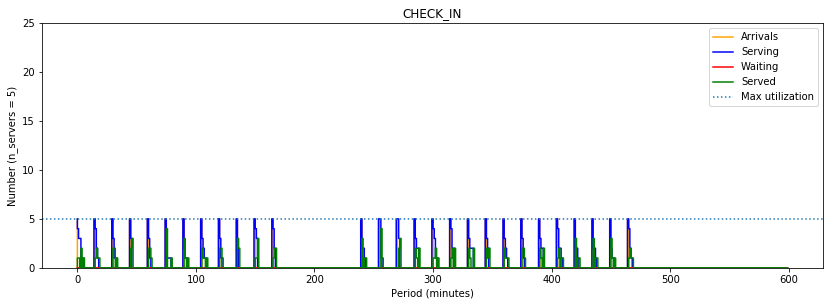

In [902]:
print ('===',processes_with_variability[0].upper(),'===\n')
print ('Total arrived: {}'.format(arrived_check_in_final))
print ('Total served: {}'.format(served_check_in_final))
print ('Mean service time: {:.2f}'.format(mean_service_time_check_in_final))
print ('Mean n_patients waiting: {:.2f}'.format(mean_patients_waiting_check_in_final))
print ('Mean waiting time: {:.2f}'.format(mean_waiting_time_check_in_final))
print ('Mean time in system: {:.2f}'.format(mean_waiting_time_check_in_final + mean_service_time_check_in_final))
print ('Mean waiting time for those who waited: {:.2f}'.format(np.mean(waiting_time_list_check_in)))

fig, ax1 = plt.subplots(figsize = (14, 4.5))

ax1.step(periods, check_in['Arrivals'], c = 'orange', label = 'Arrivals')
ax1.step(periods, check_in['Serving'], c = 'blue', label = 'Serving')
ax1.step(periods, check_in['Waiting'], c = 'red', label = 'Waiting')
ax1.step(periods, check_in['Completed'], c = 'green', label = 'Served')

ax1.axhline(servers_check_in, ls = ':', label = 'Max utilization')

ax1.set_ylim(0, 25)#max(check_in.iloc[:, :-1].max().max(), servers_check_in) + 5)
ax1.set_xlabel('Period (minutes)')
ax1.set_ylabel('Number (n_servers = {})'.format(servers_check_in))
ax1.set_title(processes_with_variability[0].upper())

plt.legend(bbox_to_anchor = (1, 1))
plt.show()

In [903]:
# Summary stats for refine_complaint
arrived_refine_complaint_final = refine_complaint['Arrivals'].sum()
served_refine_complaint_final = refine_complaint['Completed'].sum()
mean_service_time_refine_complaint_final = np.mean(service_times_completed_list_refine_complaint)
mean_patients_waiting_refine_complaint_final = refine_complaint['Waiting'].mean()
mean_waiting_time_refine_complaint_final = np.sum(waiting_time_list_refine_complaint) / served_refine_complaint_final

=== REFINE_COMPLAINT ===

Total arrived: 140.0
Total served: 140.0
Mean service time: 24.01
Mean n_patients waiting: 0.74
Mean waiting time: 3.19
Mean time in system: 27.19
Mean waiting time for those who waited: 6.19


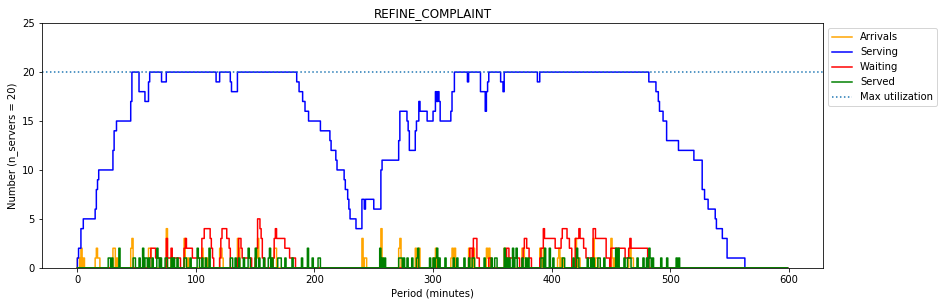

In [913]:
print ('===',processes_with_variability[1].upper(),'===\n')
print ('Total arrived: {}'.format(arrived_refine_complaint_final))
print ('Total served: {}'.format(served_refine_complaint_final))
print ('Mean service time: {:.2f}'.format(mean_service_time_refine_complaint_final))
print ('Mean n_patients waiting: {:.2f}'.format(mean_patients_waiting_refine_complaint_final))
print ('Mean waiting time: {:.2f}'.format(mean_waiting_time_refine_complaint_final))
print ('Mean time in system: {:.2f}'.format(mean_waiting_time_refine_complaint_final\
                                            + mean_service_time_refine_complaint_final))
print ('Mean waiting time for those who waited: {:.2f}'.format(np.mean(waiting_time_list_refine_complaint)))

fig, ax1 = plt.subplots(figsize = (14, 4.5))

ax1.step(periods, refine_complaint['Arrivals'], c = 'orange', label = 'Arrivals')
ax1.step(periods, refine_complaint['Serving'], c = 'blue', label = 'Serving')
ax1.step(periods, refine_complaint['Waiting'], c = 'red', label = 'Waiting')
ax1.step(periods, refine_complaint['Completed'], c = 'green', label = 'Served')

ax1.axhline(servers_refine_complaint, ls = ':', label = 'Max utilization')

ax1.set_ylim(0, 25)#max(refine_complaint.iloc[:, :-1].max().max(), servers_refine_complaint) + 5)
ax1.set_xlabel('Period (minutes)')
ax1.set_ylabel('Number (n_servers = {})'.format(servers_refine_complaint))
ax1.set_title(processes_with_variability[1].upper())

plt.legend(bbox_to_anchor = (1, 1))
plt.show()

In [905]:
# Summary stats for exam
arrived_exam_final = exam['Arrivals'].sum()
served_exam_final = exam['Completed'].sum()
mean_service_time_exam_final = np.mean(service_times_completed_list_exam_provider) # Changed to _provider
mean_patients_waiting_exam_final = exam['Waiting'].mean()
mean_waiting_time_exam_final = np.sum(waiting_time_list_exam_provider) / served_exam_final # Changed to _provider

=== EXAM ===

Total arrived: 140.0
Total served: 140.0
Mean service time: 28.34
Mean n_patients waiting: 1.07
Mean waiting time: 4.61
Mean time in system: 32.95
Mean waiting time for those who waited: 7.50


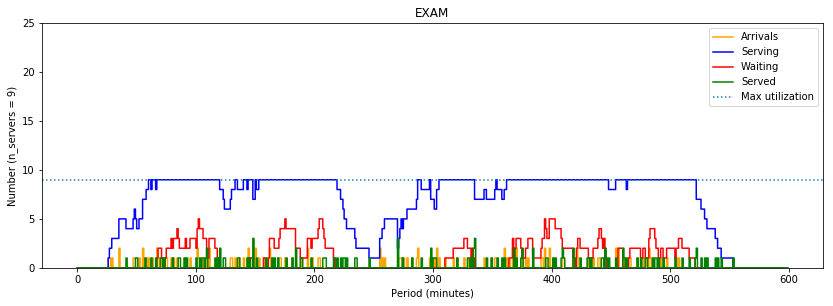

In [906]:
print ('===',processes_with_variability[2].upper(),'===\n')
print ('Total arrived: {}'.format(arrived_exam_final))
print ('Total served: {}'.format(served_exam_final))
print ('Mean service time: {:.2f}'.format(mean_service_time_exam_final))
print ('Mean n_patients waiting: {:.2f}'.format(mean_patients_waiting_exam_final))
print ('Mean waiting time: {:.2f}'.format(mean_waiting_time_exam_final))
print ('Mean time in system: {:.2f}'.format(mean_waiting_time_exam_final + mean_service_time_exam_final))
print ('Mean waiting time for those who waited: {:.2f}'.format(np.mean(waiting_time_list_exam_provider)))

fig, ax1 = plt.subplots(figsize = (14, 4.5))

ax1.step(periods, exam['Arrivals'], c = 'orange', label = 'Arrivals')
ax1.step(periods, exam['Serving'], c = 'blue', label = 'Serving')
ax1.step(periods, exam['Waiting'], c = 'red', label = 'Waiting')
ax1.step(periods, exam['Completed'], c = 'green', label = 'Served')

ax1.axhline(servers_exam_provider, ls = ':', label = 'Max utilization')

ax1.set_ylim(0, 25)#max(exam.iloc[:, :-1].max().max(), servers_exam_provider) + 5)
ax1.set_xlabel('Period (minutes)')
ax1.set_ylabel('Number (n_servers = {})'.format(servers_exam_provider))
ax1.set_title(processes_with_variability[2].upper())

plt.legend(bbox_to_anchor = (1, 1))
plt.show()

In [907]:
# Summary stats for follow_up
arrived_follow_up_final = followup['Arrivals'].sum()
served_follow_up_final = followup['Completed'].sum()
mean_service_time_follow_up_final = np.mean(service_times_completed_list_follow_up)
mean_patients_waiting_follow_up_final = followup['Waiting'].mean()
mean_waiting_time_follow_up_final = np.sum(waiting_time_list_follow_up) / served_follow_up_final

=== FOLLOW_UP ===

Total arrived: 140.0
Total served: 140.0
Mean service time: 5.29
Mean n_patients waiting: 0.00
Mean waiting time: 0.00
Mean time in system: 5.29
Mean waiting time for those who waited: nan


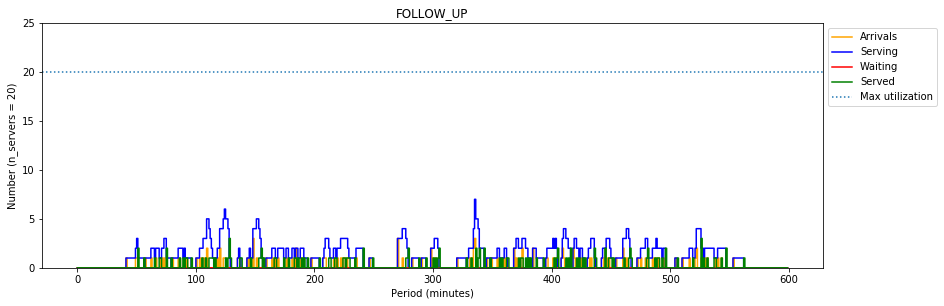

In [908]:
print ('===',processes_with_variability[3].upper(),'===\n')
print ('Total arrived: {}'.format(arrived_follow_up_final))
print ('Total served: {}'.format(served_follow_up_final))
print ('Mean service time: {:.2f}'.format(mean_service_time_follow_up_final))
print ('Mean n_patients waiting: {:.2f}'.format(mean_patients_waiting_follow_up_final))
print ('Mean waiting time: {:.2f}'.format(mean_waiting_time_follow_up_final))
print ('Mean time in system: {:.2f}'.format(mean_waiting_time_follow_up_final + mean_service_time_follow_up_final))
print ('Mean waiting time for those who waited: {:.2f}'.format(np.mean(waiting_time_list_follow_up)))

fig, ax1 = plt.subplots(figsize = (14, 4.5))

ax1.step(periods, followup['Arrivals'], c = 'orange', label = 'Arrivals')
ax1.step(periods, followup['Serving'], c = 'blue', label = 'Serving')
ax1.step(periods, followup['Waiting'], c = 'red', label = 'Waiting')
ax1.step(periods, followup['Completed'], c = 'green', label = 'Served')

ax1.axhline(servers_follow_up, ls = ':', label = 'Max utilization')

ax1.set_ylim(0, 25)#max(checkout.iloc[:, :-1].max().max(), servers_checkout) + 5)
ax1.set_xlabel('Period (minutes)')
ax1.set_ylabel('Number (n_servers = {})'.format(servers_follow_up))
ax1.set_title(processes_with_variability[3].upper())

plt.legend(bbox_to_anchor = (1, 1))
plt.show()

In [909]:
# Summary stats for checkout
arrived_checkout_final = checkout['Arrivals'].sum()
served_checkout_final = checkout['Completed'].sum()
mean_service_time_checkout_final = np.mean(service_times_completed_list_checkout)
mean_patients_waiting_checkout_final = checkout['Waiting'].mean()
mean_waiting_time_checkout_final = np.sum(waiting_time_list_checkout) / served_checkout_final

=== CHECKOUT ===

Total arrived: 140.0
Total served: 140.0
Mean service time: 5.62
Mean n_patients waiting: 0.00
Mean waiting time: 0.00
Mean time in system: 5.62
Mean waiting time for those who waited: nan


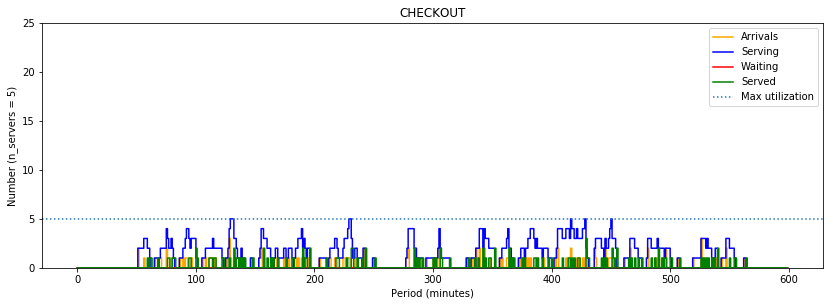

In [910]:
print ('===',processes_with_variability[4].upper(),'===\n')
print ('Total arrived: {}'.format(arrived_checkout_final))
print ('Total served: {}'.format(served_checkout_final))
print ('Mean service time: {:.2f}'.format(mean_service_time_checkout_final))
print ('Mean n_patients waiting: {:.2f}'.format(mean_patients_waiting_checkout_final))
print ('Mean waiting time: {:.2f}'.format(mean_waiting_time_checkout_final))
print ('Mean time in system: {:.2f}'.format(mean_waiting_time_checkout_final + mean_service_time_checkout_final))
print ('Mean waiting time for those who waited: {:.2f}'.format(np.mean(waiting_time_list_checkout)))

fig, ax1 = plt.subplots(figsize = (14, 4.5))

ax1.step(periods, checkout['Arrivals'], c = 'orange', label = 'Arrivals')
ax1.step(periods, checkout['Serving'], c = 'blue', label = 'Serving')
ax1.step(periods, checkout['Waiting'], c = 'red', label = 'Waiting')
ax1.step(periods, checkout['Completed'], c = 'green', label = 'Served')

ax1.axhline(servers_checkout, ls = ':', label = 'Max utilization')

ax1.set_ylim(0, 25)#max(checkout.iloc[:, :-1].max().max(), servers_checkout) + 5)
ax1.set_xlabel('Period (minutes)')
ax1.set_ylabel('Number (n_servers = {})'.format(servers_checkout))
ax1.set_title(processes_with_variability[4].upper())

plt.legend(bbox_to_anchor = (1, 1))
plt.show()

In [911]:
print ('Mean time check_in: {:.2f}'.format(mean_waiting_time_check_in_final + mean_service_time_check_in_final))
print ('Mean time waiting room -> refine complaint: {:.2f}'\
       .format(mean_waiting_time_refine_complaint_final + mean_service_time_refine_complaint_final))
print ('Mean time exam: {:.2f}'.format(mean_waiting_time_exam_final + mean_service_time_exam_final))
print ('Mean time follow_up: {:.2f}'.format(mean_waiting_time_follow_up_final + mean_service_time_follow_up_final))
print ('Mean time checkout: {:.2f}'.format(mean_waiting_time_checkout_final + mean_service_time_checkout_final))
total_time_in_system_final = mean_waiting_time_check_in_final + mean_service_time_check_in_final\
        + mean_waiting_time_refine_complaint_final + mean_service_time_refine_complaint_final\
        + mean_waiting_time_exam_final + mean_service_time_exam_final\
        + mean_waiting_time_follow_up_final + mean_service_time_follow_up_final\
        + mean_waiting_time_checkout_final + mean_service_time_checkout_final
print ('Mean time TOTAL: {:.2f}'.format(total_time_in_system_final))

Mean time check_in: 2.43
Mean time waiting room -> refine complaint: 27.19
Mean time exam: 32.95
Mean time follow_up: 5.29
Mean time checkout: 5.62
Mean time TOTAL: 73.48


In [912]:
print ('Estimated time - preventative:', process_flow['Time_Mean'].sum()\
                            + base_case_types.loc[base_case_types['Type'] == 'Preventative', 'Time_Mean'].item())
print ('Estimated time - chronic:', process_flow['Time_Mean'].sum()\
                            + base_case_types.loc[base_case_types['Type'] == 'Chronic', 'Time_Mean'].item())
print ('Estimated time - acute:', process_flow['Time_Mean'].sum()\
                            + base_case_types.loc[base_case_types['Type'] == 'Acute', 'Time_Mean'].item())

Estimated time - preventative: 64.0
Estimated time - chronic: 64.0
Estimated time - acute: 49.0
